In [1]:
from fastai.vision.all import *
from kornia import rgb_to_grayscale
import torch.nn as nn
import warnings
import random, textwrap
import os, glob
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage import util
from skimage import exposure
from scipy import ndimage
from datetime import datetime
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)

In [2]:
def plot_filters_multi_channel(t, path=''):

    #get the number of kernels
    num_kernels = t.shape[0]

    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels

    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))

    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)

        #for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()
    if path != '':
        plt.savefig(path)
    plt.show()

## TRANSFORMATIONS
def no_trans(base):
    return base

# random noise
def rnd_noise(base):
    original_image = np.array(base).astype('uint8')
    base_noise = random_noise(original_image)
    return Image.fromarray(np.uint8(base_noise*255))

# color inversion
def col_inv(base):
    original_image = np.array(base).astype('uint8')
    base_inv = np.invert(original_image)
    return Image.fromarray(np.uint8(base_inv))

# contrast correction
def cont_corr(base):
    original_image = np.array(base).astype('uint8')
    v_min, v_max = np.percentile(original_image, (15, 85))
    base_contr = exposure.rescale_intensity(original_image, in_range=(v_min, v_max))
    return Image.fromarray(np.uint8(base_contr))

# gamma correction
def gamma_corr(base):
    original_image = np.array(base).astype('uint8')
    base_gamma = exposure.adjust_gamma(original_image, gamma=0.4, gain=0.9)
    return Image.fromarray(np.uint8(base_gamma))

# log correction
def log_corr(base):
    original_image = np.array(base).astype('uint8')
    base_log = exposure.adjust_log(original_image)
    return Image.fromarray(np.uint8(base_log))

# horizontal flip
def hflip(base):
    original_image = np.array(base).astype('uint8')
    base_hflip = original_image[:, ::-1]
    return Image.fromarray(np.uint8(base_hflip))

# blur
def blur(base):
    original_image = np.array(base).astype('uint8')
    base_blur = ndimage.uniform_filter(original_image, size=(10, 10, 1))
    return Image.fromarray(np.uint8(base_blur))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # V1 layers
        self.V1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=7 // 2),  # + self.vfb,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # V2 layers
        self.V2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # V4 layers
        self.V4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # IT layers
        self.IT = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # decoding layer
        self.decoder = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(512, 2),
        )

    def forward(self, inp):

        # v4 = torch.zeros(512, 256, 3, 3).to("cuda")
        # vIT = torch.zeros(256, 128, 3, 3).to("cuda")
        # v2 = torch.zeros(256, 128, 3, 3).to("cuda")
        # v1 = torch.zeros(128, 64, 3, 3).to("cuda")
        x = inp.to("cuda")

        v1 = self.V1(x).to("cuda")
        v2 = self.V2(v1).to("cuda")
        v4 = self.V4(v2).to("cuda")
        vIT = self.IT(v4).to("cuda")
        out = self.decoder(vIT).to("cuda")

        return out

def show_images(before, after):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(before, cmap='gray')
    ax[0].set_title("Original image")

    ax[1].imshow(after, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()

def label_from_path(path):
    split_name = path.stem.split("_")
    return "same" if (split_name[-1] == split_name[-2]) else "different"

def display_images(
    images: [Image.Image],
    columns=5, width=20, height=8, max_images=15,
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.tight_layout()

        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size);

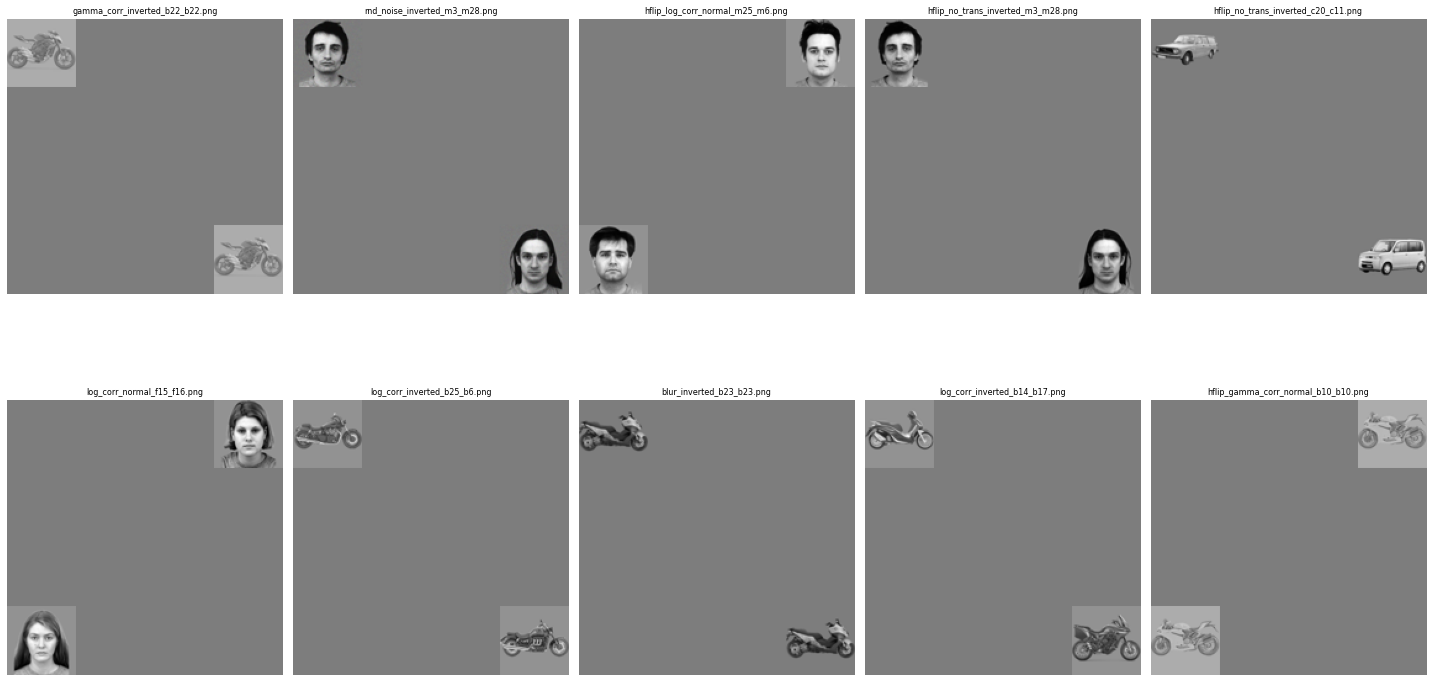

In [3]:
root = r"C:\Users\45027900\Desktop\model_old\data\original"
outroot = os.path.join(root, 'samediff')
os.makedirs(outroot, exist_ok=True)
stim_paths = glob.glob(os.path.join(root, '*.png'))

stims_dict = {path: {'category': os.path.basename(path)[0], 'id':os.path.basename(path).split('.')[0][1:]} for path in stim_paths}

cat_index = ["m","f","c","b"]
orientations = ['normal','inverted']

stim_order = np.zeros((len(cat_index), len(np.unique([int(stims_dict[item]['id']) for item in stims_dict])) * 2, 2))
stim_ids = np.sort(np.unique([int(stims_dict[item]['id']) for item in stims_dict]))

for stim_row in range(len(stim_ids)):
    for cat_id in range(len(cat_index)):
        # same
        stim_order[cat_id, stim_row, 0] = stim_ids[stim_row]
        stim_order[cat_id, stim_row, 1] = stim_ids[stim_row]

        # diff
        stim_order[cat_id, stim_row + len(stim_ids), 0] = stim_ids[stim_row]
        stim_order[cat_id, stim_row + len(stim_ids), 1] = np.flip(stim_ids)[stim_row]

ordered_stim_dict = {orientation : {
                        cat_index[category_id]: {
                            stim_pair_id: {
                                'stim1':str(int(stim_order[category_id, stim_pair_id, 0])),
                                'stim2':str(int(stim_order[category_id, stim_pair_id, 1])),
                                'same':stim_order[category_id, stim_pair_id, 0] == stim_order[category_id, stim_pair_id, 1]
                            } for stim_pair_id in range(len(stim_order[category_id]))
                        } for category_id in range(stim_order.shape[0])
                    } for orientation in orientations}

# trans_list = ['no_trans','rnd_noise','col_inv','cont_corr','gamma_corr','log_corr','blur']
# hflip_bool = [True,False]

# for orientation in orientations:
#     for cat_id in ordered_stim_dict[orientation]:
#         for pair_id in ordered_stim_dict[orientation][cat_id]:
#             for trans in trans_list:
#                 for hflip_bool_ in hflip_bool:
#                     bg = (125,125,125)
#                     base = Image.new('RGB', (224, 224), bg)

#                     im1_path = os.path.join(root, cat_id + str(ordered_stim_dict[orientation][cat_id][pair_id]['stim1']) + '.png')
#                     im2_path = os.path.join(root, cat_id + str(ordered_stim_dict[orientation][cat_id][pair_id]['stim2']) + '.png')

#                     im1 = Image.open(im1_path)
#                     im2 = Image.open(im2_path)

#                     if hflip_bool_:
#                         im1 = hflip(im1)
#                         im2 = hflip(im2)

#                     im1 = locals()[trans](im1)
#                     im2 = locals()[trans](im2)

#                     # regular images
#                     if orientation == 'normal':
#                         im1.thumbnail((224 // 4, 224//4))
#                         base.paste(im1, (224 - im1.size[0],0))
#                         im2.thumbnail((224//4, 224//4))
#                         base.paste(im2, (0, 224 - im2.size[0]))
#                     else:
#                         im1.thumbnail((224 // 4, 224//4))
#                         base.paste(im1, (0, 0))
#                         im2.thumbnail((224//4, 224//4))
#                         base.paste(im2, (224 - im2.size[0], 224 - im2.size[0]))

#                     filename = trans + '_' + orientation + '_' + cat_id + str(ordered_stim_dict[orientation][cat_id][pair_id]['stim1']) + '_' + cat_id + str(ordered_stim_dict[orientation][cat_id][pair_id]['stim2']) + '.png'
#                     if hflip_bool_:
#                         filename = 'hflip_' + filename
#                     out_dir = os.path.join(outroot, filename)

#                     print(filename)
#                     base.save(out_dir)

pairs = glob.glob(os.path.join(outroot, '*.png'))
display_images([Image.open(i) for i in random.sample(pairs, 10)])

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck

Showing first batch...


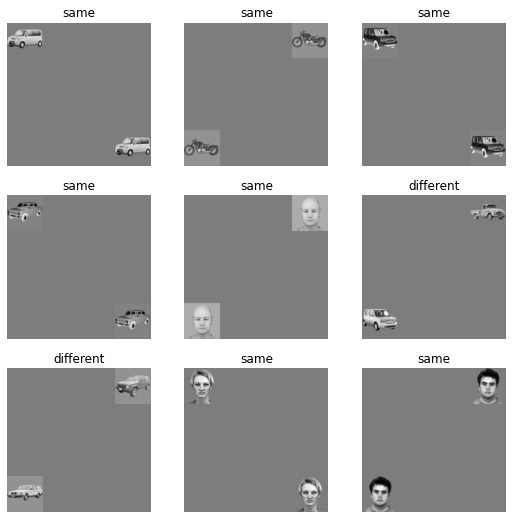

In [4]:
# init dataloaders
#stim_path = Path(outroot)
stim_path = Path(r'C:\Users\45027900\Desktop\model_old\data\original\samediff')
fnames = sorted(get_image_files(stim_path))
dls = ImageDataLoaders.from_path_func(stim_path, fnames, label_from_path, valid_pct=0.2, seed=42, shuffle=True, device='cuda:0', bs=32)
dls.num_workers = -1
print('\nShowing first batch...')
dls.show_batch()

In [5]:
## init net and pass one image
net = Net().cuda()
#weights_path = Path(r"C:\Users\45027900\Desktop\project\net.pt")

#if weights_path.is_file():
#    ckpt_data = torch.load(weights_path)
#    state_dict = ckpt_data
#    state_dict.pop("FB.0.weight")
#    state_dict.pop("FB.0.bias")
#    state_dict["decoder.2.weight"] = torch.rand((2, 512))
#    state_dict["decoder.2.bias"] = torch.rand((2))
#    net.load_state_dict(state_dict)
#    print('weights loaded!')

image = dls.one_batch()[0][0].unsqueeze(0)
net(image).shape

torch.Size([1, 2])

In [6]:
#init learner
def split_layers(model):
    return [params(model.V1),params(model.V2),params(model.V4),params(model.IT), params(model.decoder)]

learner = Learner(dls, net, metrics=accuracy, loss_func=CrossEntropyLossFlat(), opt_func=SGD, splitter=split_layers)
learner.unfreeze()
learner.summary()

Net (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9472       True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 56 x 56  
Conv2d                                    73856      True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 256 x 28 x 28  
Conv2d                                    295168     True      
ReLU                                                           
MaxPool2d                                                      
__________________________________________________________

C:\Users\45027900\Anaconda3\envs\PyTorch\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


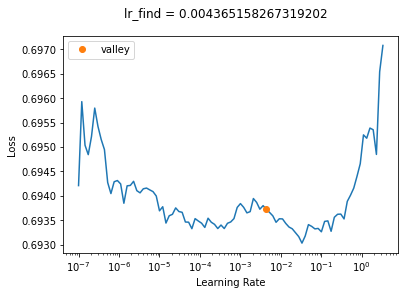

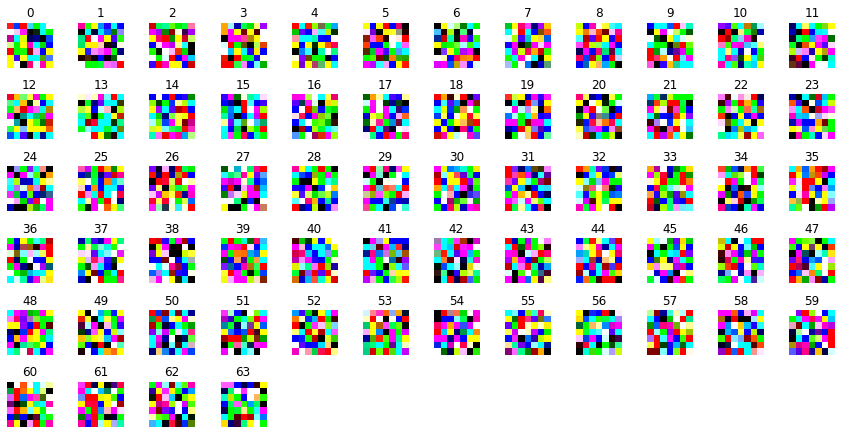

In [7]:
## SET LEARNING RATE PARAMS (ONE CYCLE POLICY), TRAIN AND PLOT LR AND ACC
# this gives us the best learning rate. see https://github.com/sgugger/Deep-Learning/blob/master/Understanding%20the%20new%20fastai%20API%20for%20scheduling%20training.ipynb

#with learn.no_bar(), learn.no_logging():
timestamp = datetime.now().strftime("%d-%b-%Y_%H-%M-%S")
root = r'C:\Users\45027900\Desktop\project\chk\fastai'
path = os.path.join(root,timestamp)
os.makedirs(path, exist_ok=True)

metrics_dict = {'train_loss':[],'valid_loss':[],'accuracy':[]}

n_epoch = 500

div = 10
moms=(0.95, 0.85, 0.95)
#lr_max = 0.001
lr_max = learner.lr_find()[0]
plt.suptitle(f'lr_find = {lr_max}')
plt.savefig(os.path.join(path,'lr_find.png'))
plt.show()

#learner.load(os.path.join(path, '05-Oct-2021_22-34-41_EPOCH-1x3000_fastai.pth'))

weights_start = learner.model.V1[0].weight.data.cpu()
fig_path = os.path.join(path,'weights_start.png')
plot_filters_multi_channel(weights_start, path = fig_path)

EPOCH 1 - START - 13-Oct-2021_12-20-59


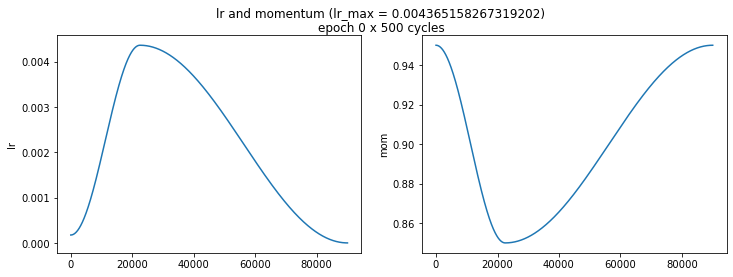

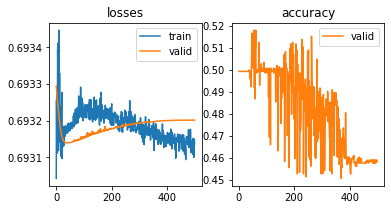

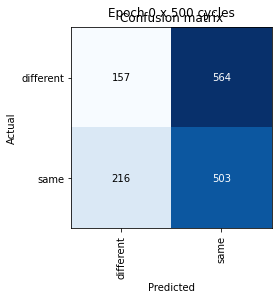

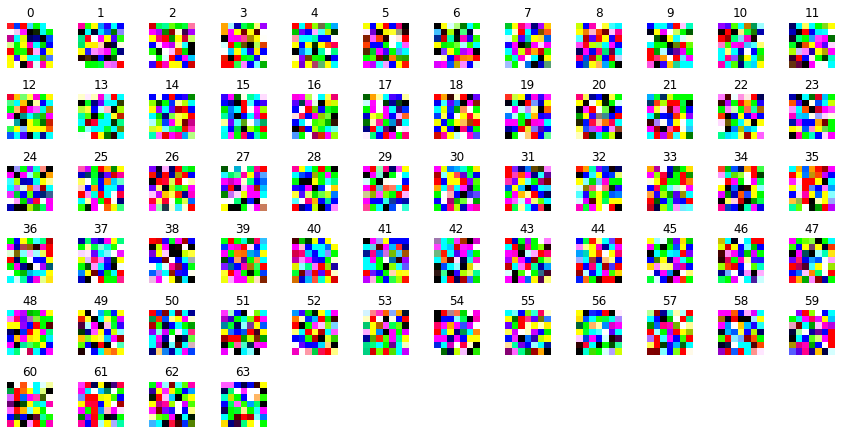

EPOCH 1 - END - 2021-10-13 15:36:00.160387
time: 3:15:00.753034
left: 2 days, 13:45:14.307646
EPOCH 2 - START - 13-Oct-2021_12-20-59


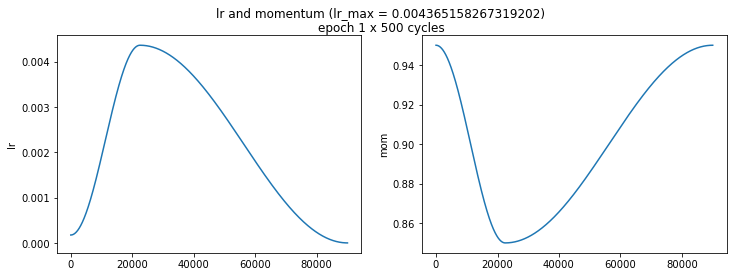

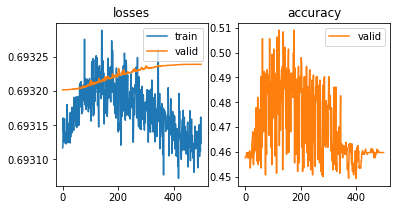

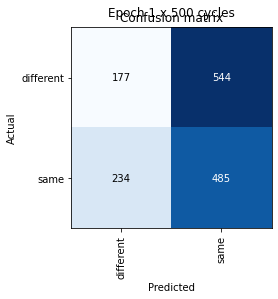

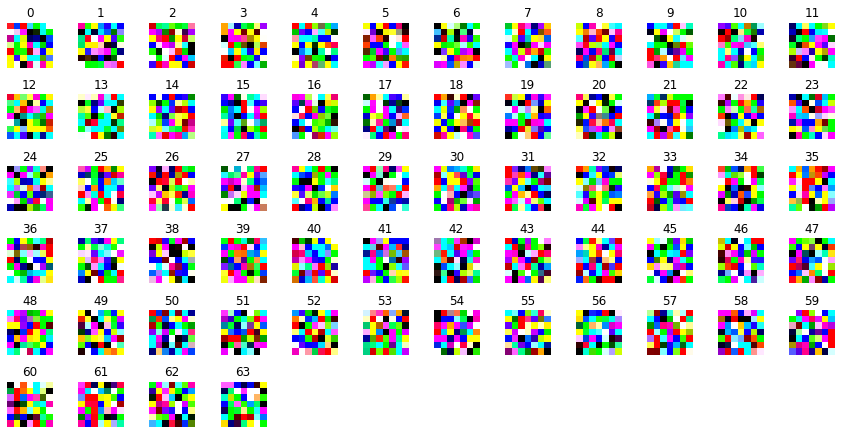

EPOCH 2 - END - 2021-10-13 18:41:12.498932
time: 3:05:12.338545
left: 2 days, 7:33:42.093810
EPOCH 3 - START - 13-Oct-2021_12-20-59


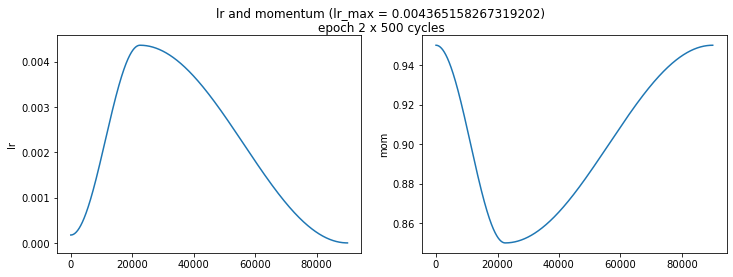

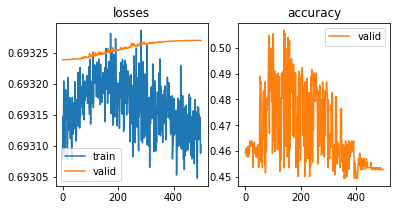

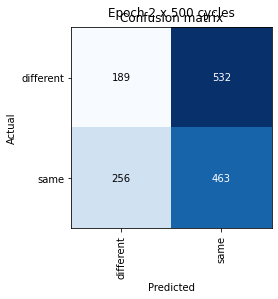

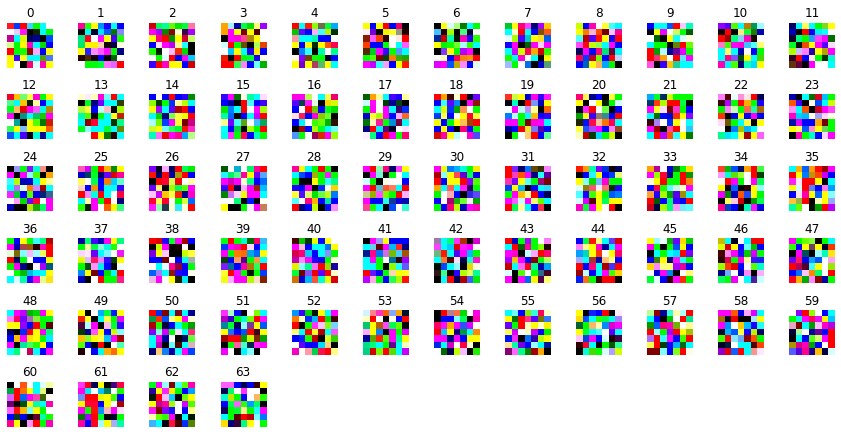

EPOCH 3 - END - 2021-10-13 21:43:54.565372
time: 3:02:42.066440
left: 2 days, 3:45:55.129480
EPOCH 4 - START - 13-Oct-2021_12-20-59


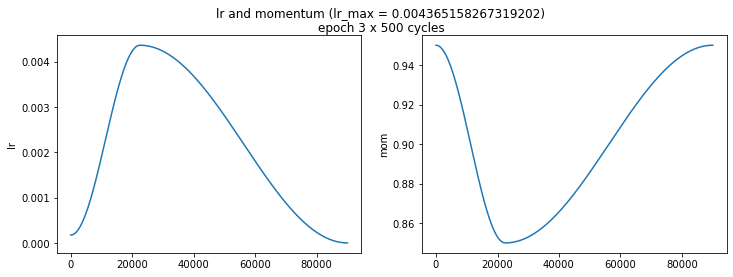

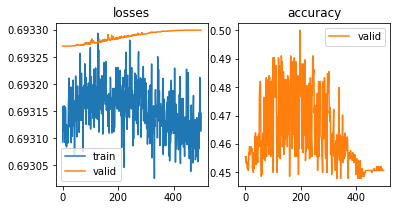

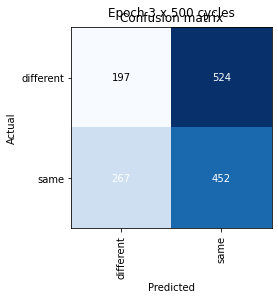

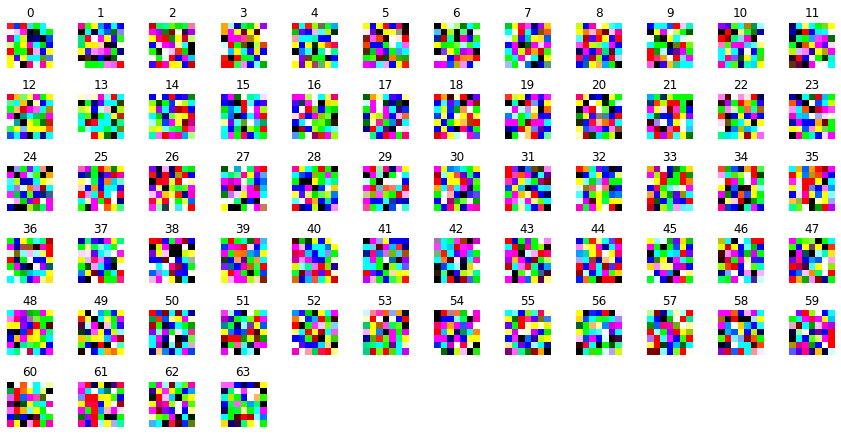

EPOCH 4 - END - 2021-10-14 00:47:41.247613
time: 3:03:46.666619
left: 2 days, 1:00:26.665904
EPOCH 5 - START - 13-Oct-2021_12-20-59


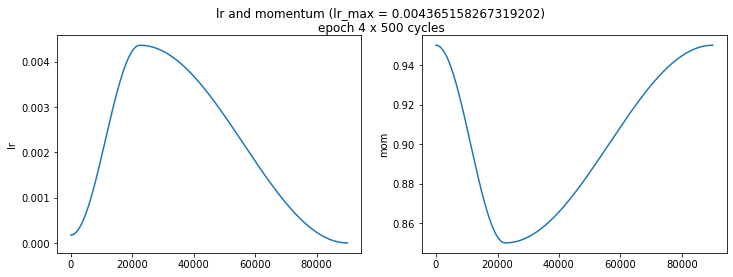

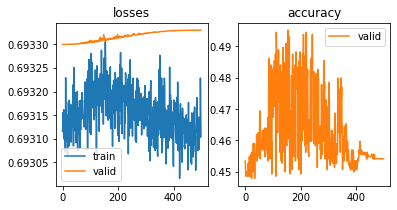

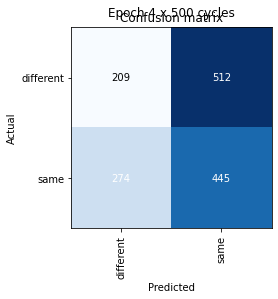

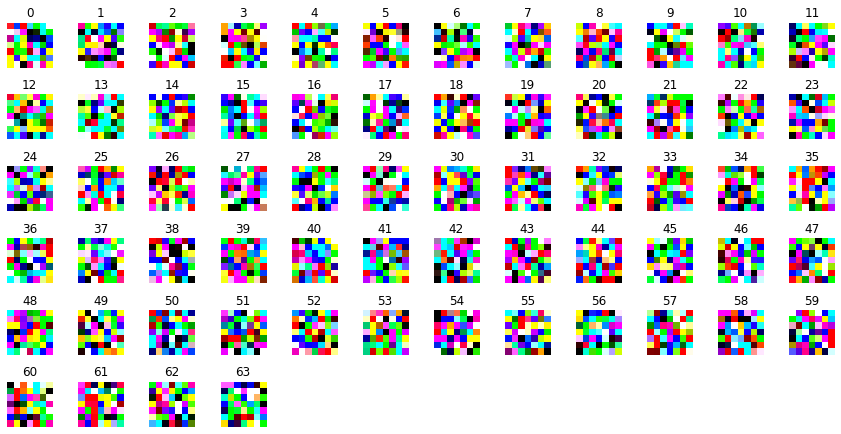

EPOCH 5 - END - 2021-10-14 03:54:22.216313
time: 3:06:40.968700
left: 1 day, 22:40:14.530500
EPOCH 6 - START - 13-Oct-2021_12-20-59


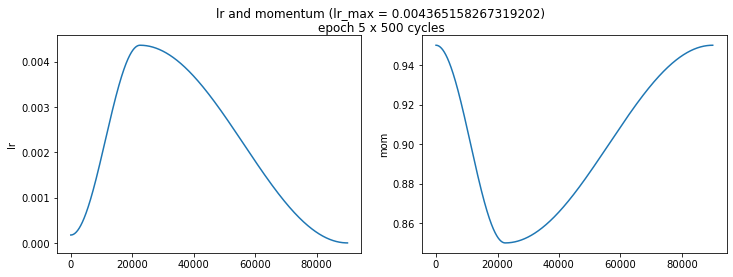

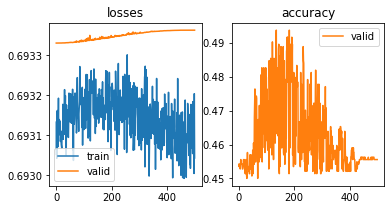

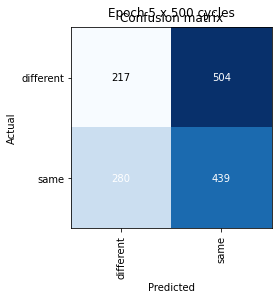

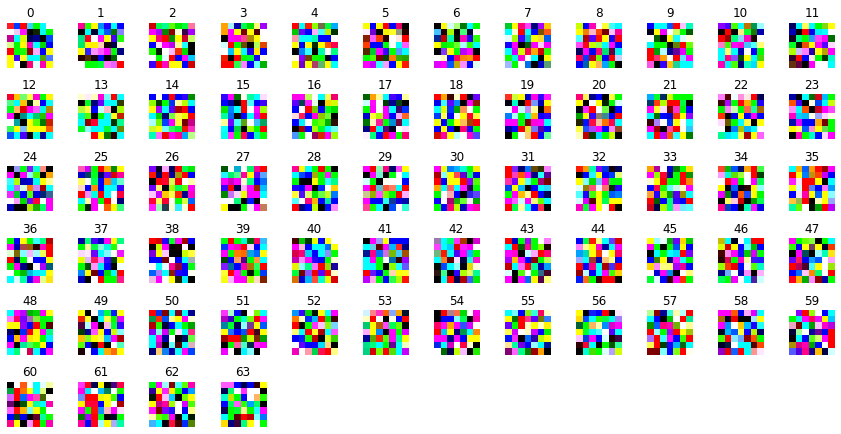

EPOCH 6 - END - 2021-10-14 07:00:59.839664
time: 3:06:37.623351
left: 1 day, 19:32:46.726914
EPOCH 7 - START - 13-Oct-2021_12-20-59


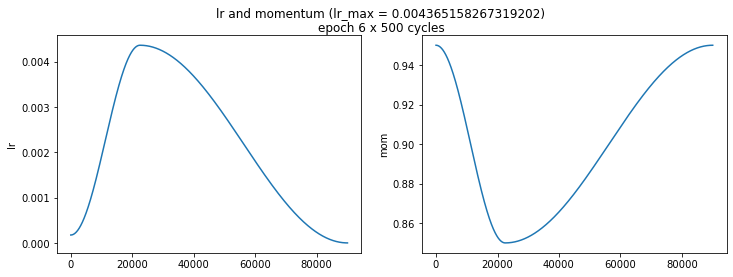

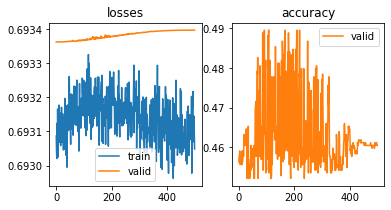

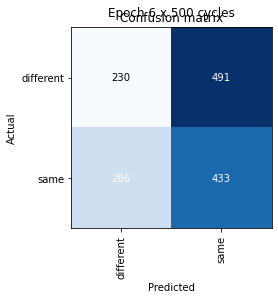

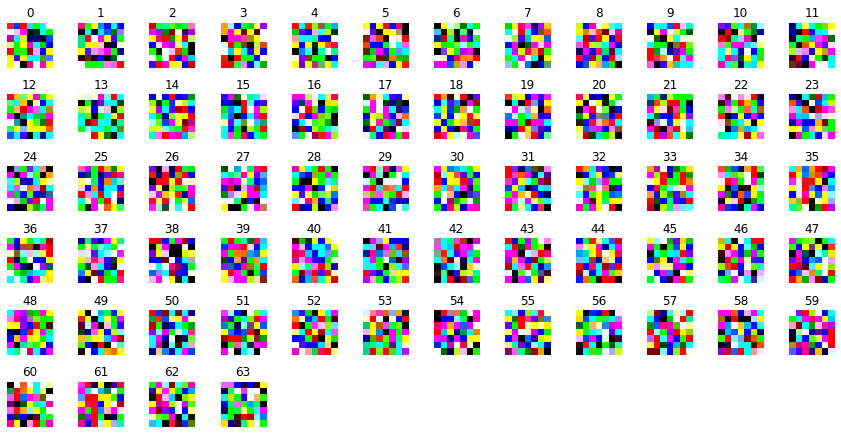

EPOCH 7 - END - 2021-10-14 10:07:40.213195
time: 3:06:40.373531
left: 1 day, 16:26:44.855903
EPOCH 8 - START - 13-Oct-2021_12-20-59


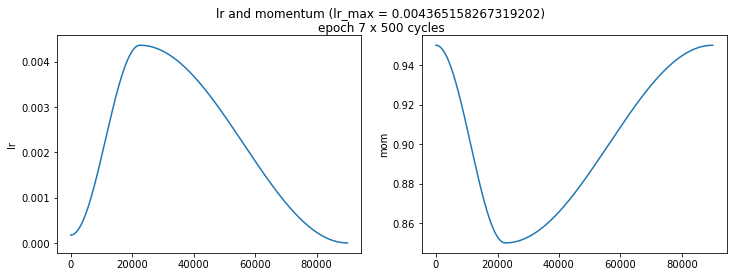

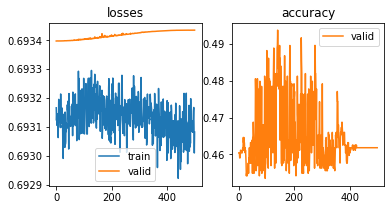

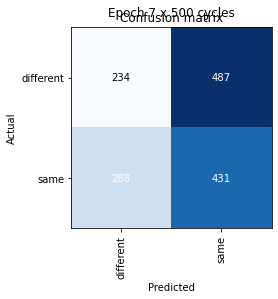

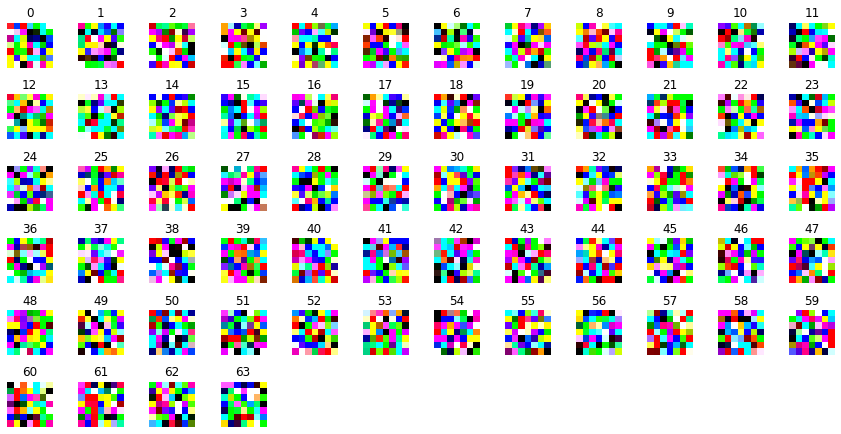

EPOCH 8 - END - 2021-10-14 13:12:39.258637
time: 3:04:59.045442
left: 1 day, 12:59:48.545304
EPOCH 9 - START - 13-Oct-2021_12-20-59


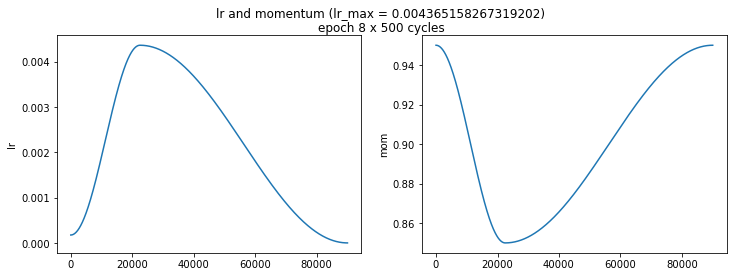

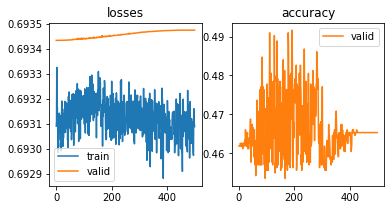

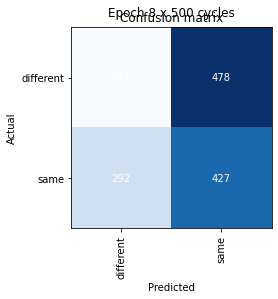

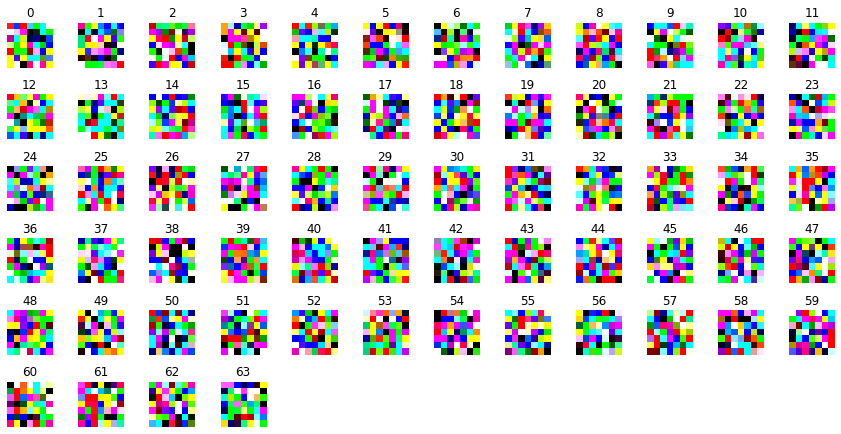

EPOCH 9 - END - 2021-10-14 16:17:33.944542
time: 3:04:54.685905
left: 1 day, 9:54:01.544955
EPOCH 10 - START - 13-Oct-2021_12-20-59


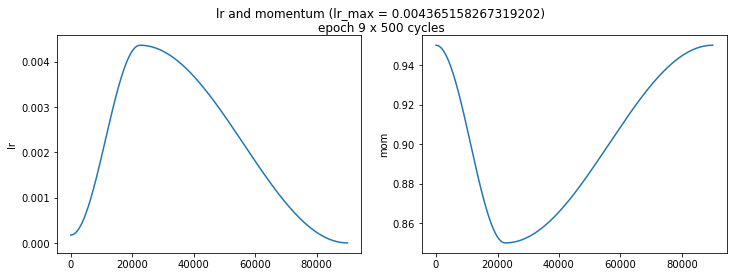

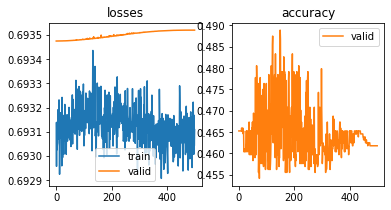

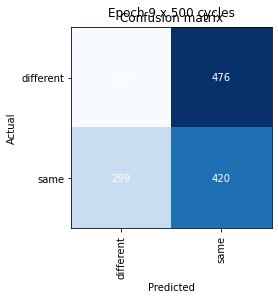

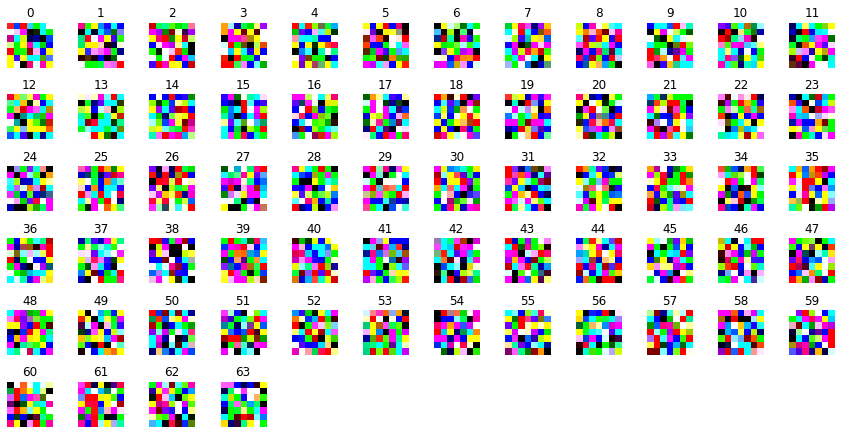

EPOCH 10 - END - 2021-10-14 19:22:18.224867
time: 3:04:44.280325
left: 1 day, 6:47:22.803250
EPOCH 11 - START - 13-Oct-2021_12-20-59


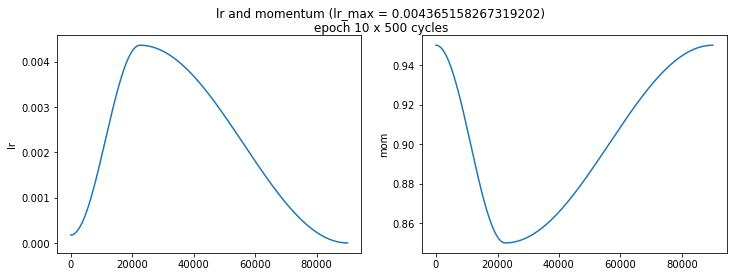

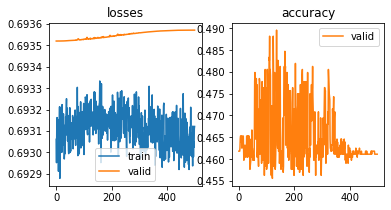

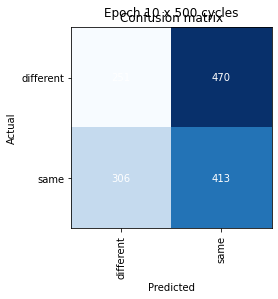

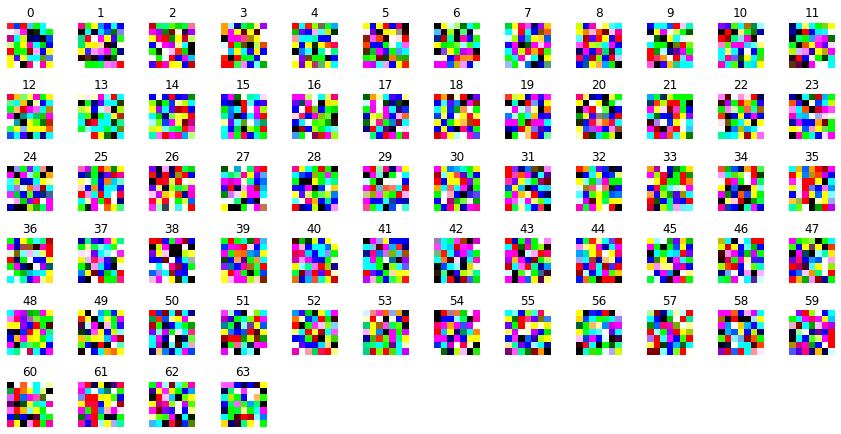

EPOCH 11 - END - 2021-10-14 22:26:54.410578
time: 3:04:36.185711
left: 1 day, 3:41:25.671399
EPOCH 12 - START - 13-Oct-2021_12-20-59


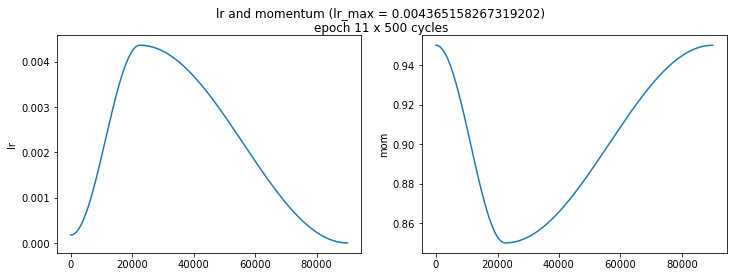

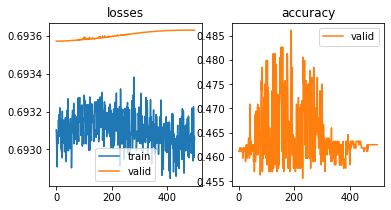

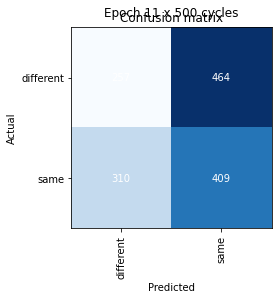

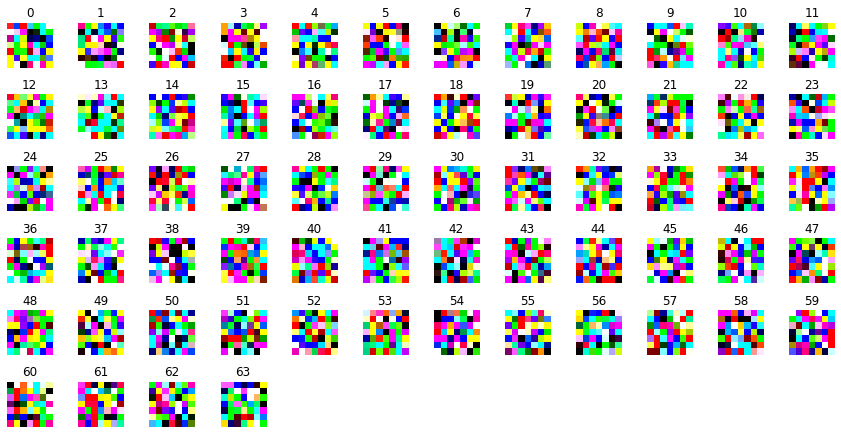

EPOCH 12 - END - 2021-10-15 01:32:10.128612
time: 3:05:15.718034
left: 1 day, 0:42:05.744272
EPOCH 13 - START - 13-Oct-2021_12-20-59


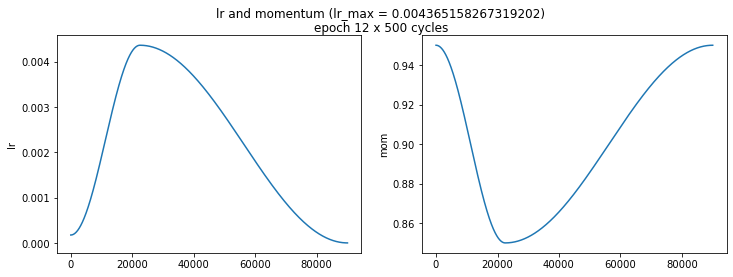

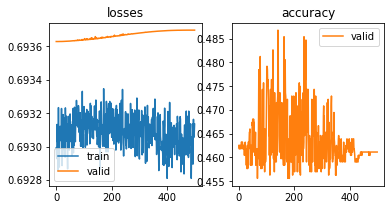

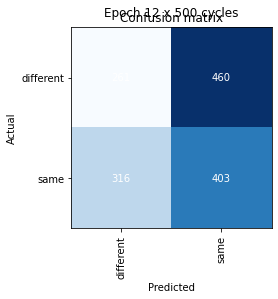

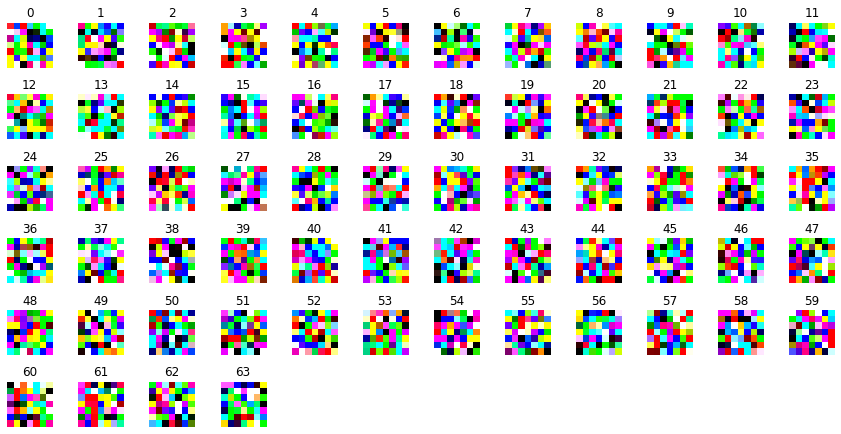

EPOCH 13 - END - 2021-10-15 04:39:30.815028
time: 3:07:20.686416
left: 21:51:24.804912
EPOCH 14 - START - 13-Oct-2021_12-20-59


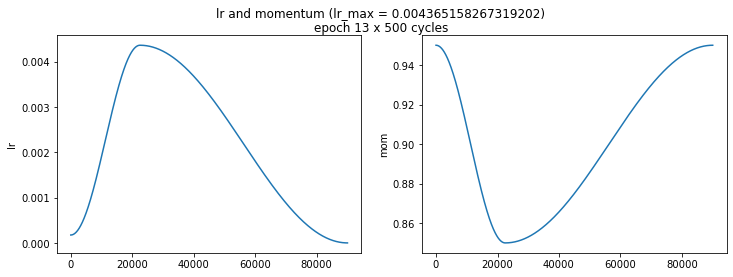

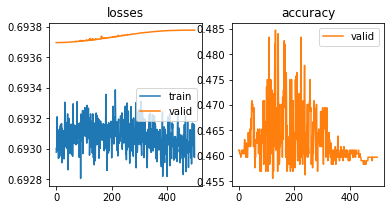

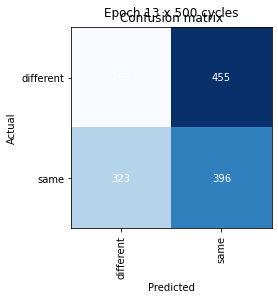

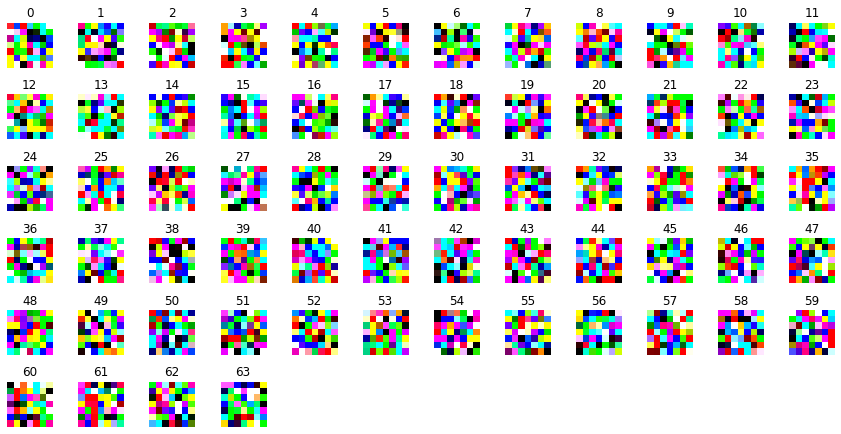

EPOCH 14 - END - 2021-10-15 07:45:55.541591
time: 3:06:24.710942
left: 18:38:28.265652
EPOCH 15 - START - 13-Oct-2021_12-20-59


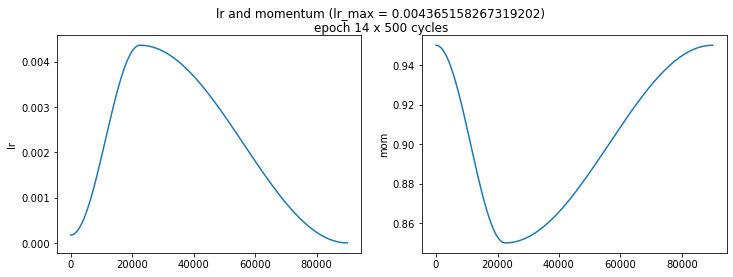

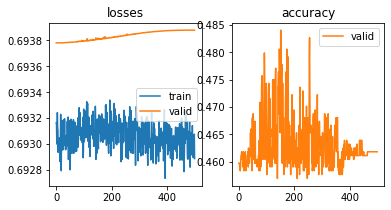

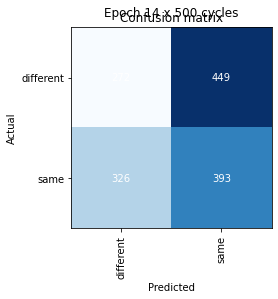

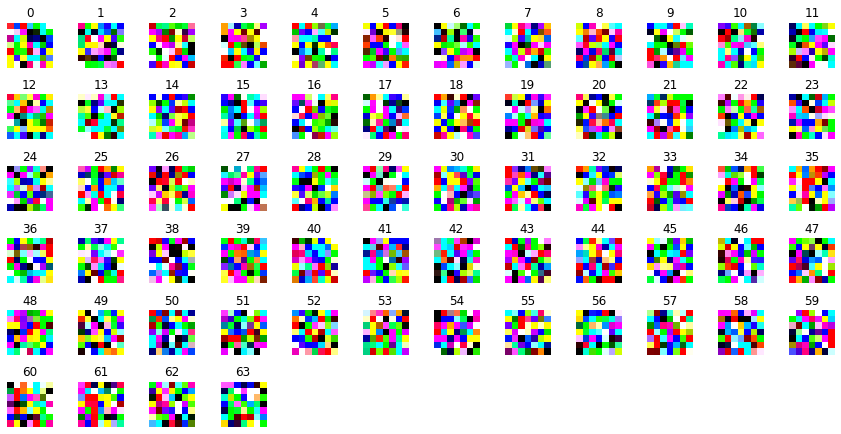

EPOCH 15 - END - 2021-10-15 10:51:06.352434
time: 3:05:10.810843
left: 15:25:54.054215
EPOCH 16 - START - 13-Oct-2021_12-20-59


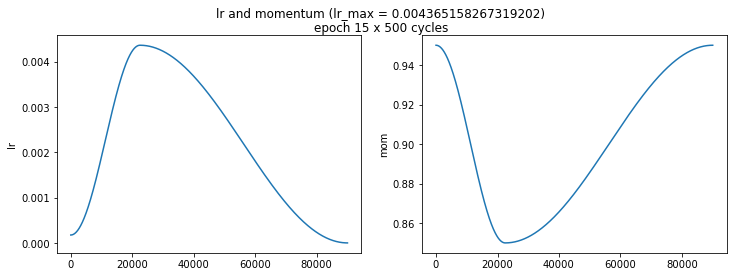

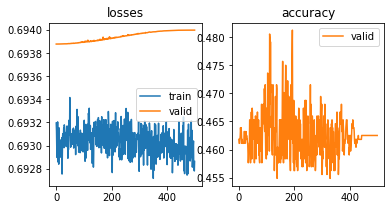

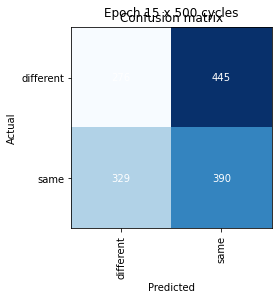

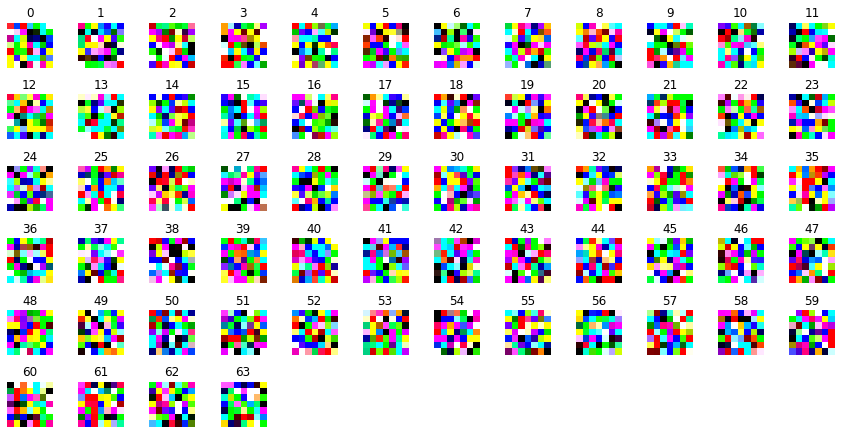

EPOCH 16 - END - 2021-10-15 13:55:24.508570
time: 3:04:18.156136
left: 12:17:12.624544
EPOCH 17 - START - 13-Oct-2021_12-20-59


KeyboardInterrupt: 

In [8]:
timestamp = datetime.now().strftime("%d-%b-%Y_%H-%M-%S")
epochs = 20
for epoch in range(epochs):
    with learner.no_logging(), learner.no_bar():
        # START
        start = datetime.now()
        print(f'EPOCH {str(epoch + 1)} - START - {timestamp}')

        # FIT
        learner.fit_one_cycle(n_epoch=n_epoch,lr_max=lr_max, moms=moms)#,div=div, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=10))

        # PLOT LEARNING RATE
        learner.recorder.plot_sched() # plot learning rate and mom
        plt.suptitle(f'lr and momentum (lr_max = {lr_max})\nepoch {epoch} x {n_epoch} cycles')
        plt.savefig(os.path.join(path,f'lr_mom_{epoch}x{n_epoch}.png'))
        plt.show()

        # SAVE MODEL
        file = os.path.join(path, f'{timestamp}_EPOCH-{epoch}x{n_epoch}_fastai.pth')
        learner.save(file, with_opt=True, pickle_protocol=2)

        # SAVE AND PLOT METRICS
        i = 0
        for metric in learner.recorder.metric_names:
            if metric in metrics_dict.keys():
                metrics_dict[metric].append(learner.recorder.values[0][i])
                i =+ 1

        recorder = learner.recorder
        metrics =  np.stack(recorder.values)
        names = recorder.metric_names[1:-1]
        n = len(names) -1
        fig, axs = subplots(1, 2)
        axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]

        for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
                ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
                ax.set_title(name if i > 1 else 'losses')
                ax.legend(loc='best')
        plt.savefig(os.path.join(path,f'metrics_{epoch}x{n_epoch}.png'))

        #learner.show_results()

        interp = ClassificationInterpretation.from_learner(learner)
        #interp.plot_top_losses(15)

        # PLOT CONFUSION MATRIX
        interp.plot_confusion_matrix()
        plt.suptitle(f'Epoch {epoch} x {n_epoch} cycles')
        plt.savefig(os.path.join(path,f'confmat_{epoch}x{n_epoch}.png'))

        # PLOT WEIGHTS
        weights_end = learner.model.V1[0].weight.data.cpu()
        fig_path = os.path.join(path,f'weights_{epoch}x{n_epoch}.png')
        plot_filters_multi_channel(weights_end, fig_path)

        end = datetime.now()
        print(f'EPOCH {str(epoch + 1)} - END - {end}')
        print(f'time: {end-start}')
        print(f'left: {(end-start) * (epochs - 1 - epoch)}')

In [9]:
#weights = learner.model.V1[0].weight.data.cpu()
#plot_filters_multi_channel(weights)

print(f'weights updated: {weights_start == weights_end}')

weights updated: tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  .